# Libraries and functions initialization

In [22]:
library(repr)
options(repr.plot.width=11, repr.plot.height=7, repr.plot.res = 80, repr.plot.quality = 40)
options(jupyter.plot_mimetypes = 'image/png')

setwd("~/yandexDisk/DIPLOMA/CODE/src")
source("simulations.functions.R", echo=FALSE)
source("../../OWL/O_learning_functions.r", echo=FALSE)
debug.file <- ".various.Rdata/Iter.info"
set.seed(0)

Loading SVMW


In [23]:
# Defining control execution constants 
train.data.sample.sizes <- c(50, 100, 200, 400, 800)
test.data.sample.size <- 10000
number.of.covariates = 30
sample.size <- 200
offsets = seq(0.2, 1, length = 10)
control.offset = min(offsets) / 2
lambdas = seq(0,  10,  length=12)

registerDoParallel(cores = 4)
number.of.iters <- 20

offset = 0.1
lambda = 1

In [9]:
test <- GetSimulationData(test.data.sample.size, number.of.covariates)
train <- GetSimulationData(sample.size, number.of.covariates)

# Simulation specific functions

In [46]:
GetSimulationData

function (sample.size, number.of.covariates, add.intercept = T) 
{
    covariates <- matrix(runif(sample.size * number.of.covariates, 
        min = -1, max = 1), ncol = number.of.covariates)
    if (isTRUE(add.intercept)) {
        covariates <- model.matrix(~., as.data.frame(covariates))
    }
    treatment <- matrix(runif(sample.size, min = 0, max = 2), 
        ncol = 1)
    optimal.treatment <- GetOptimalDecisionsForFirstSimulation(as.data.frame(covariates))
    q.function.values <- GetQfunctionValuesForFirstSimulation(covariates = as.data.frame(covariates), 
        given.treatement = treatment, optimal.treatment = optimal.treatment)
    reward.list <- GetRewardGivenQfunctionValuesAsMeanVec(q.function.values)
    stopifnot(is.list(reward.list))
    prop.scores <- rep(1, nrow(covariates))
    return(c(list(covariates = as.matrix(covariates), treatment = as.matrix(treatment), 
        prop.scores = as.matrix(prop.scores)), reward.list))
}

# Analysis

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


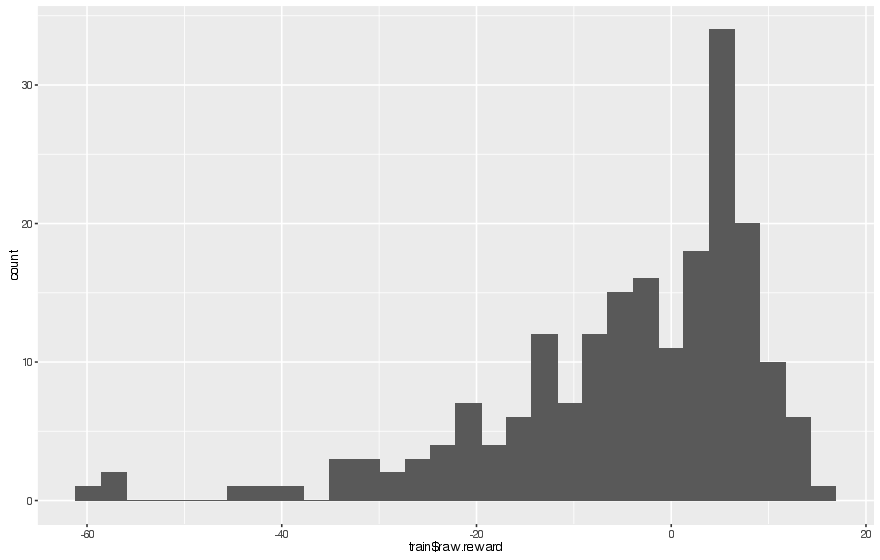

In [38]:
qplot(train$raw.reward)

# Kernel comparison for first simulation data

In [18]:
offset.grid <- seq(0.1, 3, length.out = 20)
offset.grid <- lseq(0.1, 35, 20)
# offset.grid <- c(0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1)
lambda.grid <- lambda
hyperparams.grid <- expand.grid(offset=offset.grid ) # , lambda=lambda.grid )

# Comparison of different methods for creating residuals 
### ( with regard to different train data and fixed )

In [47]:
GetMetricsForParams

function (params, datasets, offset, policy.function, lambda) 
{
    stat.list <- list()
    for (data.name in names(datasets)) {
        d = datasets[[data.name]]
        for (name in names(params)) {
            p = params[[name]]
            vf = ValueFunction(params = p, obs.data = d, offset = offset, 
                policy.function)
            objf = ObjectiveFunction(params = p, obs.data = d, 
                offset, policy.function, lambda)
            qf = QFunctionFirstScenario(p, d, policy.function)
            stat.list[[paste("VF", name, toupper(data.name), 
                sep = ".")]] = vf
            stat.list[[paste("OBJF", name, toupper(data.name), 
                sep = ".")]] = objf
            stat.list[[paste("Qfun", name, toupper(data.name), 
                sep = ".")]] = qf
        }
    }
    return(t(as.matrix(stat.list)))
}

In [6]:
global.stat <- list()

test <- GetSimulationData(test.data.sample.size, number.of.covariates)
for (i in seq(1,number.of.iters)) {
    train <- GetSimulationData(sample.size, number.of.covariates)
    # rq median model on upper 40% of the best rewards
    init.pars = GetInitPars(train, q = 0.6)
    # handmade approximate MM algorithm
    opt.params <- list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=init.pars, "approximation.eps"=1e-7)
    pars.dca.MM <- OptimizeParamsOfPolicyFunction(obs.data = train, offset = offset, policy.function = PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
    
    pars.owl <- GetOwlParams(train, lambda, weights = F)
    pars.owl.weights <- GetOwlParams(train, lambda, weights = T)
    pars.owl.dc_loop <- coef(dc_loop(train$covariates[, -1], train$treatment, train$reward, offset, 
                                     lambda, init.pars[-1], init.pars[1]))
    
#     opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars, "use.hessian"=TRUE)
#     pars.nr <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
#     opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars, "use.hessian"=FALSE)
#     pars.nr.without.hess <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)

    opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars,  "func"=CauchyObjFunc.2max, "func.grad"=CauchyObjFunc.grad.2max, "func.hess"=CauchyObjFunc.hess.2max)
    pars.cauchy <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)

    opt.decision <- c(1, 0.5, 0.5 , rep(0, length(pars.owl ) - 3))
    data.list <- list("train"=train, "test"=test)
    params.list  <- list("Init.pars"=pars.owl,
                         "MM.approx"=pars.dca.MM, 
                         "OWL.dc_loop"=pars.owl.dc_loop,
#                          "NR" =  pars.nr,
#                          "NR.without.hess" = pars.nr.without.hess, 
                         "Ideal"=opt.decision,
                         "OWL"=pars.owl, 
                         "Cauchy"=pars.cauchy, 
                         "OWL.weights"=pars.owl.weights
                        ) 
    iter.stat <- GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
    global.stat  <- rbind(global.stat, iter.stat)
}

MML2PenalizedProperIters Converged after  3  iterations
Code:  3  Message:  Last step could not find a value above the current.
Boundary of parameter space?  
Consider switching to a more robust optimisation method temporarily. 
MML2PenalizedProperIters Converged after  3  iterations
Code:  3  Message:  Last step could not find a value above the current.
Boundary of parameter space?  
Consider switching to a more robust optimisation method temporarily. 
MML2PenalizedProperIters Converged after  4  iterations
Code:  3  Message:  Last step could not find a value above the current.
Boundary of parameter space?  
Consider switching to a more robust optimisation method temporarily. 
MML2PenalizedProperIters Converged after  3  iterations
Code:  3  Message:  Last step could not find a value above the current.
Boundary of parameter space?  
Consider switching to a more robust optimisation method temporarily. 
MML2PenalizedProperIters Converged after  5  iterations
Code:  3  Message:  Last ste

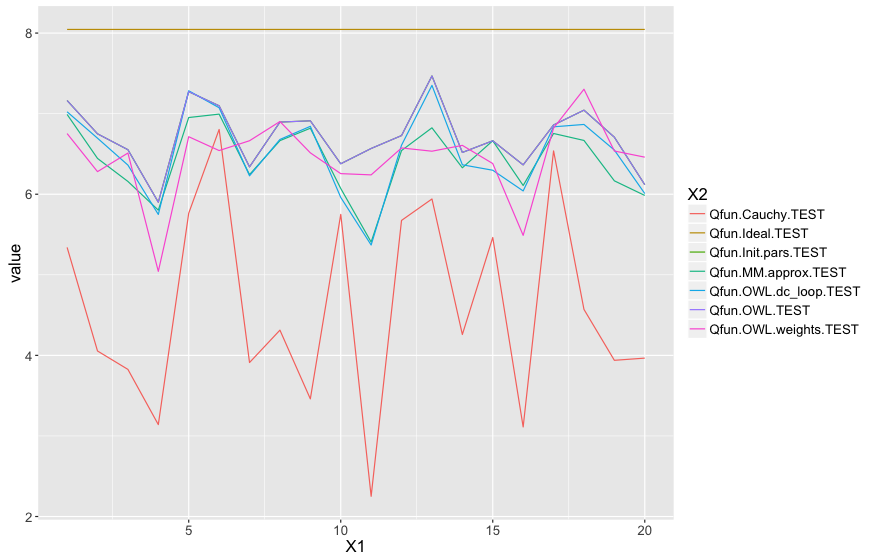

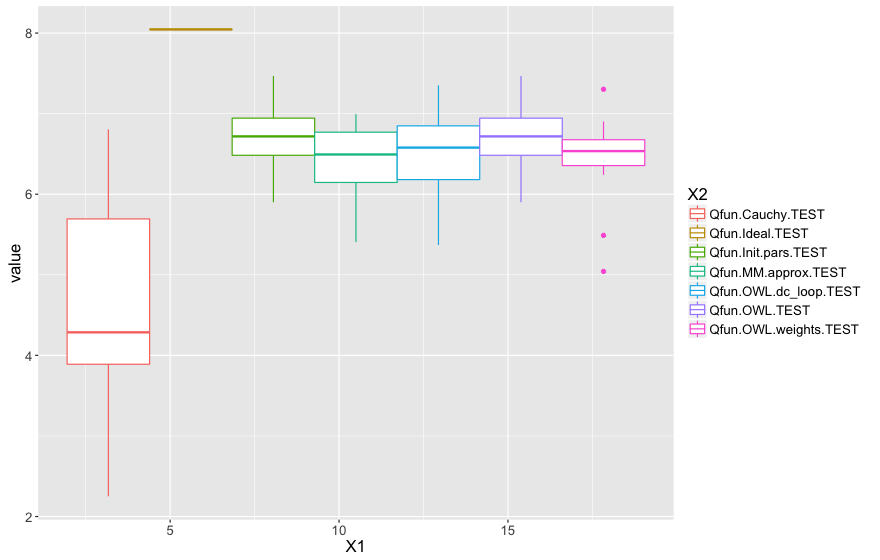

In [7]:
melt = reshape::melt
gl.stat.df <- apply(global.stat, 2, unlist)
vf.train <- melt(gl.stat.df[, grep("VF.*TRAIN", colnames(gl.stat.df))])
vf.test <- melt(gl.stat.df[, grep("VF.*TEST", colnames(gl.stat.df))])
obj.train <- melt(gl.stat.df[, grep("OBJ.*TRAIN", colnames(gl.stat.df))])
obj.test <- melt(gl.stat.df[, grep("OBJ.*TEST", colnames(gl.stat.df))])
q.train <- melt(gl.stat.df[, grep("Q.*TRAIN", colnames(gl.stat.df))])
q.test <- melt(gl.stat.df[, grep("Q.*TEST", colnames(gl.stat.df))])

# ggplot(q.train , aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(vf.train, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
ggplot(q.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(vf.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(obj.train, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(obj.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
ggplot(q.test, aes(X1, value))  + geom_boxplot(aes(colour = X2)) + theme(text = element_text(size=15))

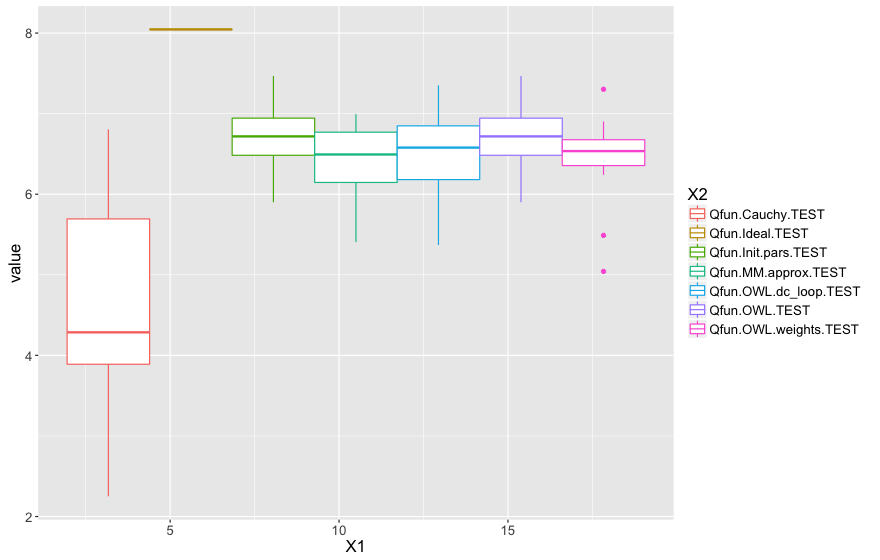

In [8]:
ggplot(q.test, aes(X1, value))  + geom_boxplot(aes(colour = X2)) + theme(text = element_text(size=15))

In [9]:
# pdf("~/yandexDisk/DIPLOMA/REPORTS/Presentations/imgs/MMvsRQ.pdf", width = 8, height=6 )
data.to.plot <-  q.test[q.test$X2 %in% c("Qfun.MM.proper.iters.TEST", "Qfun.OWL.dc_loop.TEST"), ]
ggplot(data.to.plot , aes(factor(data.to.plot$X2, labels = c("Hand implemented MM algo", 
                                                             "Out of the box quantile regression")), y=value  )) +  
    geom_boxplot() +  
    theme(text = element_text(size=20)) + 
    xlab("Algorithms") +
    ylab("Value function") +
    ggtitle("1000 simulations results")
# dev.off()

ERROR: Error in factor(data.to.plot$X2, labels = c("Hand implemented MM algo", : invalid 'labels'; length 2 should be 1 or 1


ERROR: Error in file(con, "rb"): cannot open the connection
